# ch 9 성능개선

## 9.1 과적합

### 9.1.1 데이터 증식 (Data Augmentation)
- 임의로 새로운 데이터를 만들어 학습 데이터에 추가
- 통계적 기법, 단순 변형, 생성 모델 이용

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose([tr.ToPILImage(), # 많은 기능들이 이미지 타입이 PIL이여야 작동을 함
                     tr.RandomCrop(60), # 크기가 60*60이 되도록 이미지 일부를 무작위로 잘라서 같은 이미지라도 매번 다른 입력 이미지로 모델에 들어갈 수 있게 함
                     tr.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.1),  # 이미지의 밝기, 대비 , 색조를 변형해서 새로운 이미지로 만듦
                     tr.RandomHorizontalFlip(), # 이미지를 뒤집음
                     tr.ToTensor()])


### 9.1.2 조기 종료 (Early stopping)
- 모델이 학습 데이터를 많이 공부하면 학습 데이터에 맞춰져 모델이 최적화될 수 있음
- 적당한 기준을 정하여 모델 학습을 끊는 것이 조기종료

### 9.1.3 L2 정규화 
- 경계를 만들어 학습 데이터에서의 최적변수 $w*$에 도달하지 못하게 하며 경계 안에서만 변수를 최적화하도록 함
- 따라서 모델이 최적화된다면 $v*$로 수렴하게 된다.
![스크린샷 2024-01-31 오후 7.29.18.png](<attachment:스크린샷 2024-01-31 오후 7.29.18.png>)
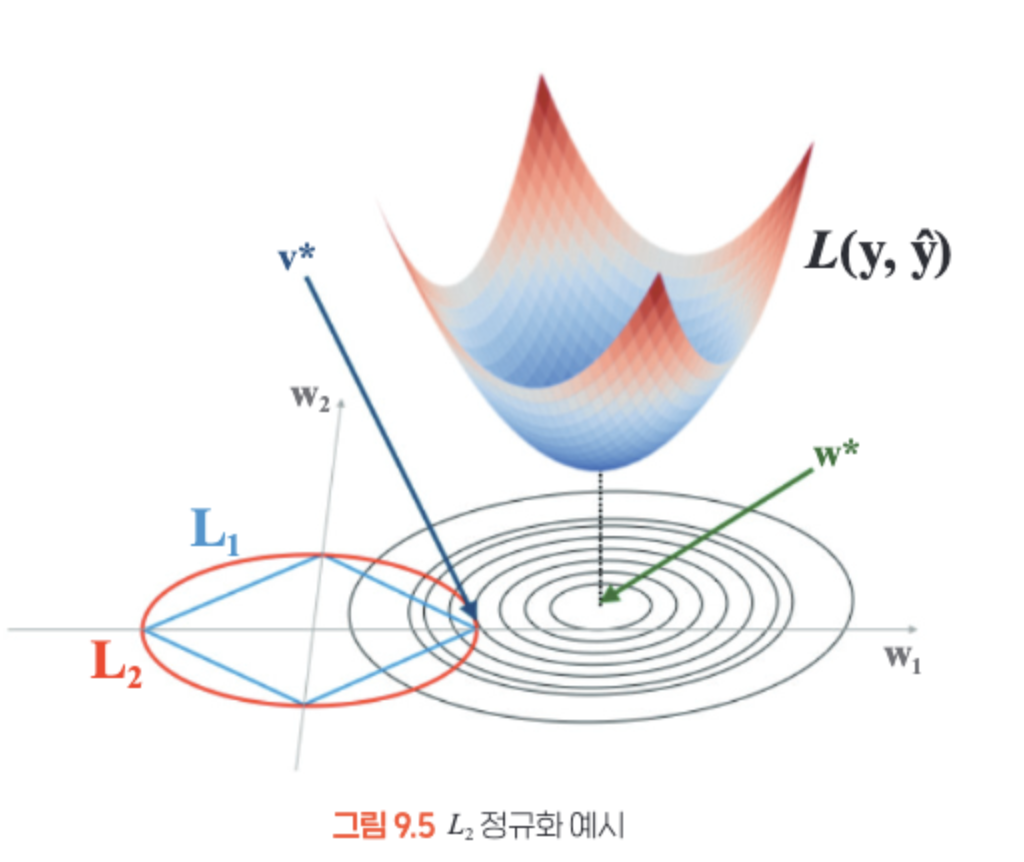

In [ ]:
# Adam을 사용할 경우 weight_decay에 L2페널티 값을 입력하여 L2정규화를 활성화 할 수 있음, 값이 클수록 제약조건이 강해짐
optimizer = optim.Adam(resnet.parameters(),lr=1e-3,weight_decay=1e-3)

### 9.1.4 드롭아웃
- 인공 신경망에서 무작위로 일정한 비율의 노드를 제외하여 학습하는 방법
- 한 번 변수 갱신이 일어날 때마다 제외된 노드와 관련 있는 변수는 갱신이 되지 않기 때문에 학습 데이터에 대한 모델 최적화를 억제할 수 있다.
![스크린샷 2024-01-31 오후 7.35.26.png](<attachment:스크린샷 2024-01-31 오후 7.35.26.png>)
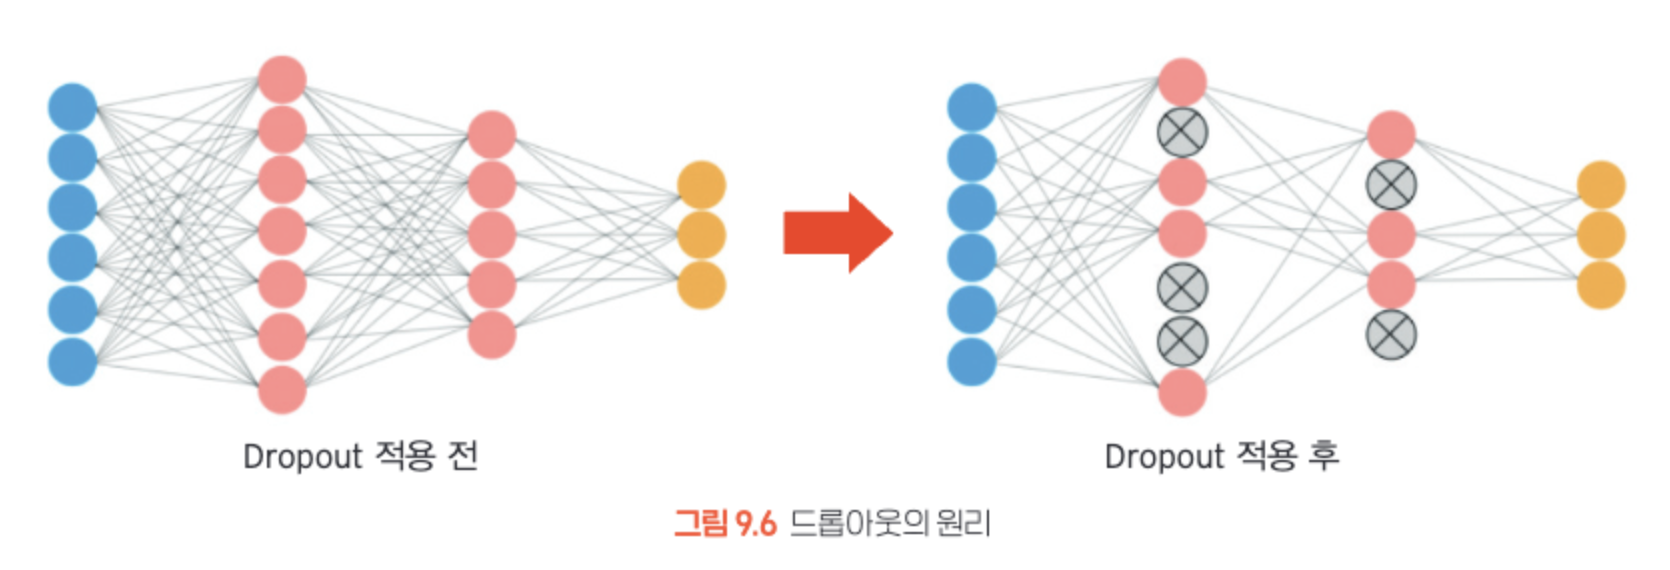

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13,50)
        self.fc2 = nn.Linear(50,1)
        self.dropout = nn.Dropout(0.5) # 해당 노드에 50%를 선택해 노드를 사용하지 않겠다는 의미

    def forward(self,x):
        x = self.dropout(F.relu(self.fc1(x))) # 여기서 노드가 50개이니까 25개의 노드가 비활성화됨
        x = F.relu(self.fc2(x)) 
        return x

### 9.1.5 배치 정규화
- 미니 배치를 이용하면 학습을 한 번 할 때마다 입력값의 분포가 다름
- 여기서 활성화 함수로 들어가기 전에 각 노드롤 들어오는 값(피처)를 보정된 정규화(normalization)을 통해서 항상 동일한 분포 위에 있게 하는 거ㅅ
- 입력값들의 분포를 일정하게 하여 일반적으로 학습에 대한 수렴 속도가 빠름
- 배치 단위의 정규화 분포는 전체의 데이터 분포와 다를 수 있기 때문에 과적합을 방지할 수 있다

![스크린샷 2024-01-31 오후 7.44.42.png](<attachment:스크린샷 2024-01-31 오후 7.44.42.png>)
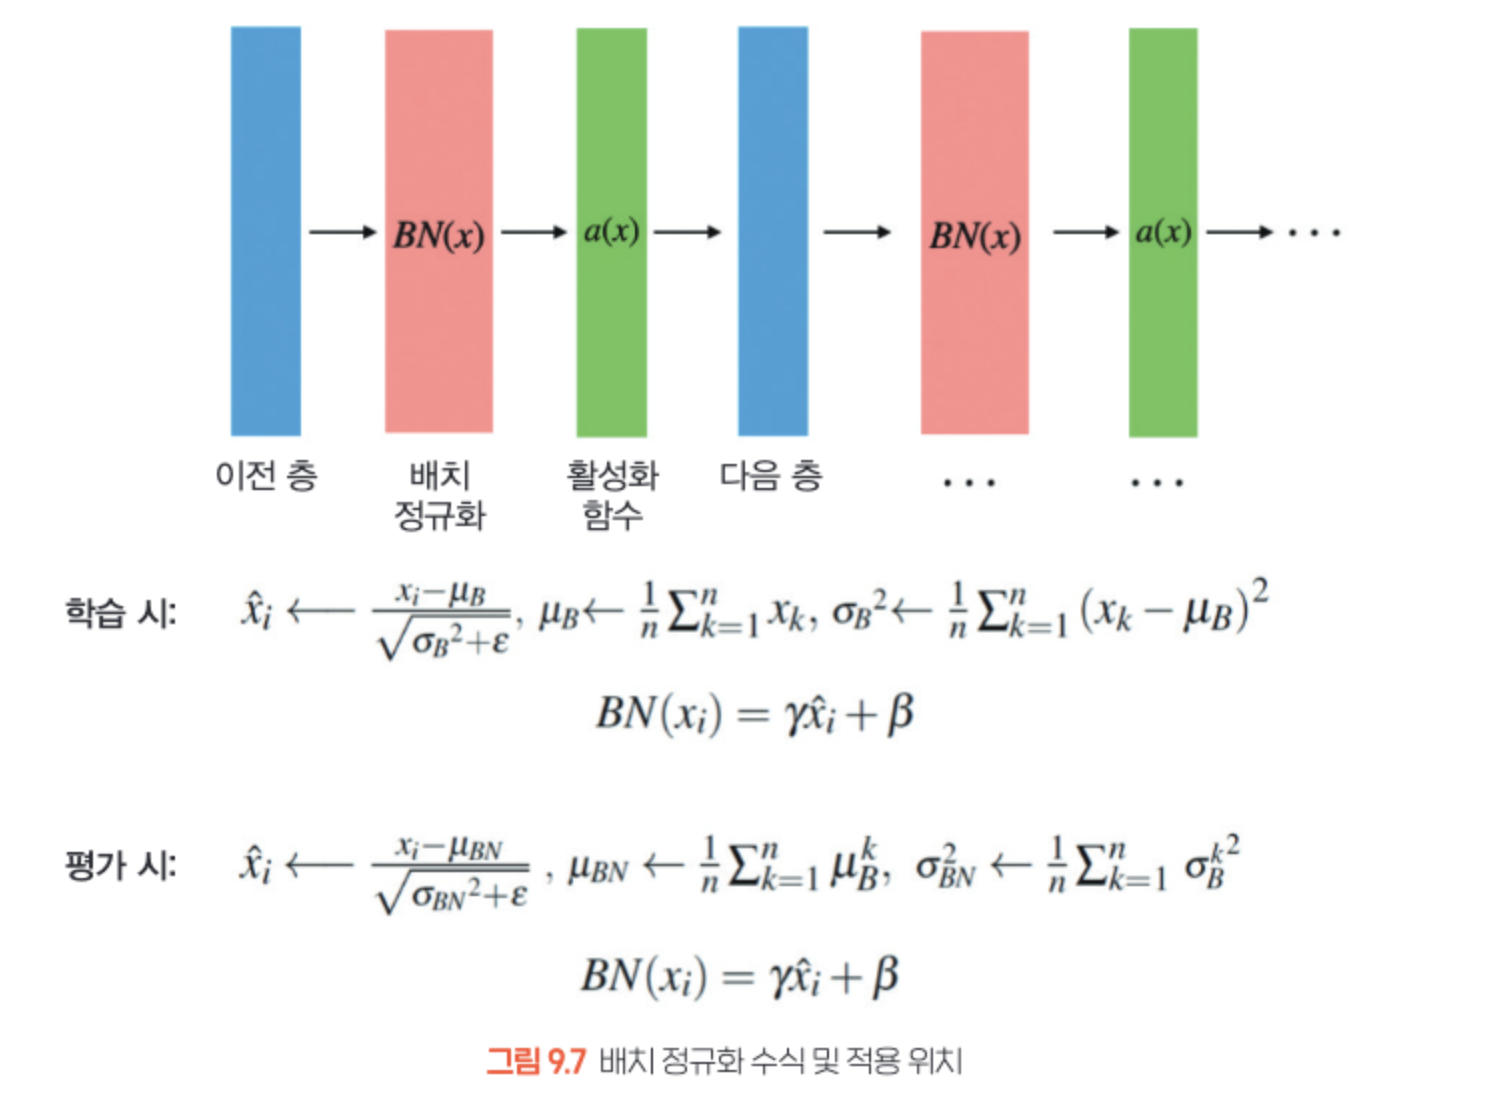

In [ ]:
# 층과 층 사이에 이 코드를 넣어준다.
            nn.BatchNorm2d()

### 9.1.6 교란 라벨 (disturb label)
- 분류 문제에서 일정 비율만큼 라벨을 의도적으로 잘못된 라벨로 만들어서 학습을 방해하는 방법

In [ ]:
# 교란 라벨 정의하기 
class DisturbLabel(torch.nn.Module):
    def __init__(self,alpha,num_classes): # 교란 라벨 비율과 클래스 수를 받는다.
        super(DisturbLabel,self).__init__()
        self.alpha = alpha
        self.C = num_classes
        self.p_c = (1-((self.C -1)/self.C)*(alpha/100)) # 실제 라벨을 뽑을 확률
        self.p_i = (1-self.p_c)/(self.C-1) # 나머지

### 9.1.7 교란 값(disturb value)
- 회귀 문제에서 일정 비율만큼 라벨에 노이즈를 주입하여 학습 데이터에 대해 최적화를 방해하는 방법
![스크린샷 2024-01-31 오후 7.50.46.png](<attachment:스크린샷 2024-01-31 오후 7.50.46.png>)
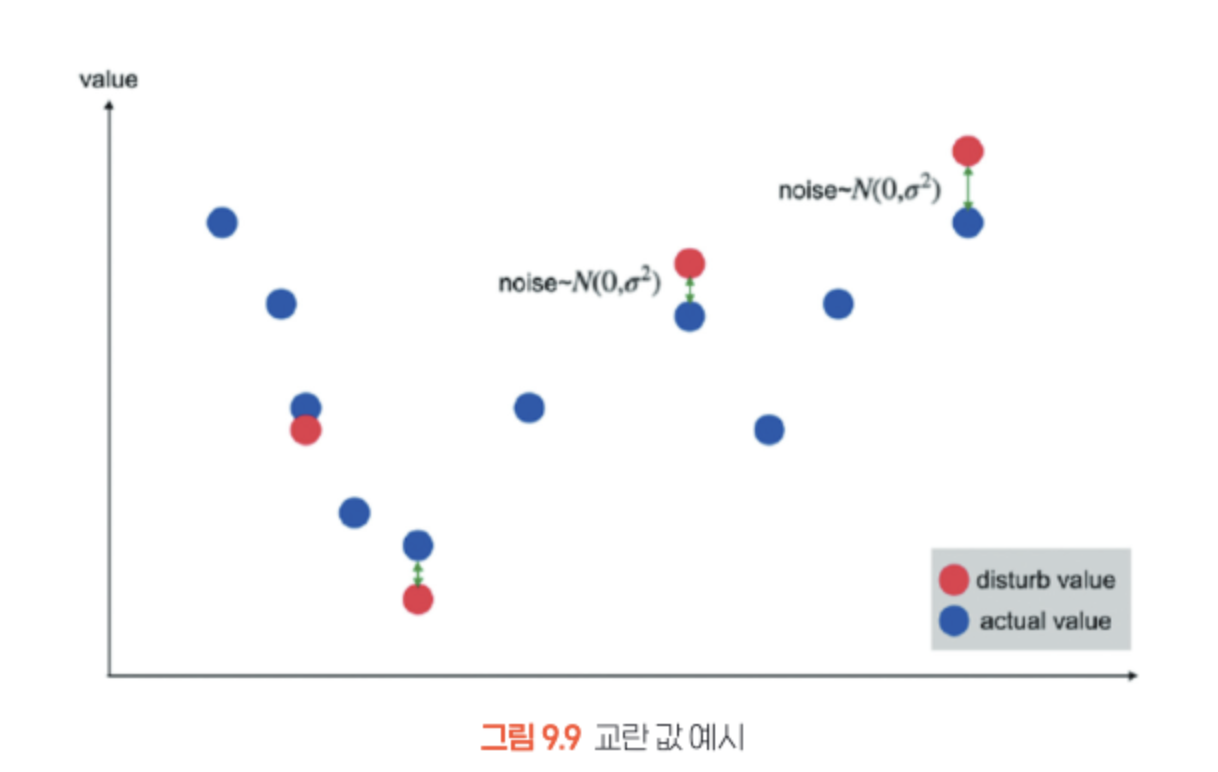

In [ ]:
# 노이즈 생성하기
def noise_generator(x,alpha):
    noise = torch.normal(0,1e-8,size=(len(x),1)) # 정규분포에 따른 노이즈 생성
    noise[torch.randint(0,len(x),(int(len(x)*(1-alpha)),))] = 0 # 노이즈 타깃이 아닌 값은 노이즈를 0으로 함
    return noise

In [ ]:
# 교란 값 선언 및 적용하기 
for epoch in range(400):
    for data in trainloader:
        inputs, values = data
        optimizer.zero_grad()
        outputs = model(inputs)
        values = values + noise_generator(values,alpha)
        loss = criterion(outputs, values)

### 9.1.3 라벨 스무딩 
- 교차 엔트로피 손실함수를 계산할 때 실제 값을 0과 1이 아닌, 예를 들어 0.1과 0.8로 구성해서 과적합을 방지하는 기술
- 0과 1을 맞춰야 하는 문제에서 예측값이 0.7이 나왔다면 원래 1을 맞추기 위해 1에 가까워지도록 학습이 될 것 
- 이때 기준을 0.8롷 낮추면 0.7만 나와도 이 정도면 맞았다고 모델이 스스로를 인정하면서 실제 값에 가깝게 가려고 하지 않고 정답을 맞히게 되어 과적합을 막아주는 개념

In [ ]:
# 라벨 스무딩 정의 및 선언하기 
class LabelSmoothingLoss(nn.Module):
    def __init__(self,classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss,self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward (self,pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing/(self.cls-1))
            true_dist.scatter_(1,target.data.unsqueeze(1),self.confidence)
        return torch.mean*(torch.sum(-true_dist*pred,dim=self.dim))

In [ ]:
# 라벨 스무딩 사용
criterion = LabelSmoothingLoss(classes = 10, smoothing=0.2)

## 9.2 데이터 불균형

- 특정 클래스에 과적합을 야기

### 9.2.1 가중 무작위 샘플링(weighted random sampling)
- 배치를 만들 때마다 각 클래스를 동일한 개수를 뽑는다면 한 번 학습 시 균형 데이터를 뽑게 하는 방법

In [ ]:
# 가중치 함수 만들기
def make_weights(labels, nclasses):
    labels = np.array(labels)
    weight_list = []
    for cls in range(nclasses):
        idx = np.where(labels == cls)[0]
        count = len(idx)
        weight = 1/count # 라벨이 뽑힐 가중치를 동일하게 해당 라벨 전체에 할당
        weight = [weight]*count
        weight_list += weight
    return weight_list

In [ ]:
# 가중치 생성하기
weights = make_weights(trainset.targets, len(trainset.classes))
weights = torch.DoubleTensor(weights)
print(weights)

In [ ]:
# 데이터 로더 생성
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights,len(weights)) # 배치를 불러올때 자동으로 클래스에 대한 균일 분포를 갖는 배치를 만든다.

### 9.2.2 가중 손실 함수
- nn.CrossEntropyLoss 는 가중 손실함수를 정의
- 여기에 weight를 입력하면 됨

In [ ]:
num_ins = [40,45,30,62,70] # 클래스 별 이미지의 개수
weights = [1-(x/sum(num_ins))for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weights=class_weights) # 데이터가 적은 클래스에 대해서 큰 가중치를 부여함으로써 업데이트 균형을 맞춤

### 9.2.3 혼동행렬(confusion matrix)
- 각 클래스의 분포와 정확도를 확인 가능

## 9.3 전이 학습 (transfer learning)
- 기존의 지식을 우리가 풀고자 하는 문제에 적용하여 학습하는 방법

### 9.3.1 사전 학습 모델 (pretrained model)

### 9.3.2 모델 프리징 (model freezing)
- 기존의 일부 모델 변수들을 그대로 사용하기 위해 업데이트가 되지 않도록 하는 방법
- 사전 학습된 변수를 그대로 유지할 수 있어 학습 속도와 정확도를 향상시킬 수 있음
- 다른 모델과 붙여 다른 구조를 만들 수도 있음

In [ ]:
# 변수 프리징하기
for i,(name,param) in enumerate(model.named_parameters()):
    param.requires_grad = False # 파라미터가 학습 시 업데이트가 되지 않도록 함
    if i == 9 :
        print('end')
        break

## 9.4 준지도 학습 (semi-supervised learning)
- 정답이 있는 데이터와 정답이 없는 데이터를 함께 사용하여 모델을 학습시키는 방법
- 더 많은 데이터를 확보하여 성능 향상에 도움을 준다

### 9.4.1 의사 라벨링 (pseudo labeling)
- 이미 학습된 모델을 이용하여 라벨링이 되지 않는 데이터를 예측한 후, 그 예측값을 기준으로 라벨링을 하여 기존의 학습 데이터와 함께 학습에 사용하는 방법
- 예측값을 라벨로 이용하기 때문에 라벨에 대한 불확실성이 존재

In [ ]:
# 준지도 학습 수행
alpha = 0 # 학습 데이터로만 모델을 최적화한다는 의미, 알파가 커질수록 의사라벨의 영향도가 커진다는 의미, 적절한 알파를 정의하는 것이 중요
alpha_t = 1e-4
T1 = 100 # 에폭 100번까지는 알파=0으로 학습을 진행 
T2 = 450 # 에폭이 450이 될 때까지 일정하게 알파를 높여 학습을 시행
best_acc=0

In [ ]:
for epoch in range(501):
    correct = 0
    total = 0
    for traindata, pseudodata in zip(trainloader, unlabeledlader):
        inputs, labels = traindata[0].to(device), traindata[1].to(device)
        pinputs = pseudodata[0].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        if alpha > 0 :
            poutputs = model(pinputs)
            _, plabels = torch.max(poutputs.detach(),1)
            loss = criterion(outputs, labels) + alpha*criterion(poutputs, plabels)
        else:
            loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _,predicted = torch.max(ouputs.detach(),1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if (epoch> T1) and (epoch<T2):
        alpha = alpha_t*(epoch-T1)/(T2-T1)
    elif epoch >= T2:
        alpha = alpha_t
    val_acc = accuracy(valloader)
    if val_acc >= best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(),'./models/cifar_model_for_pseudo_label.pth')
        print('[%d] train acc: %.2f, validation acc: %.2f - saved the best model' % (epoch, 100*correct/total, val_acc))
    elif epoch % 10 == 0:
        print('[%d] train acc: %.2f, validation acc: %.2f'%(epoch, 100*correct/total, val_acc))
